In [43]:
import pickle as pkl
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import statistics
cmd_folder = os.getenv("SESNPATH") + "/utils"
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

from templutils import *
from itertools import combinations


In [44]:
su = setupvars()
bands = su.bands

In [45]:
bands_w_p = [(b + 'p' if b in ['u', 'r', 'i'] else b) for b in bands]
types = ['IIb', 'Ib', 'Ibn', 'Ic', 'Ic-bl', 'Ib-c']

In [46]:
bands_combo = list(combinations(bands_w_p, 2))

In [47]:
output_directory = os.getenv("SESNPATH") + "extra_outputs/"
all_sne = pkl.load(open(output_directory + "all_params_for_varience_analysis.pkl", "rb"))

In [48]:
all_sne_names = list(all_sne.keys()) 
print('Found %i SNe'%len(all_sne_names))

Found 165 SNe


In [49]:
# Let's look at an example
name = 'sn2004fe'
band = 'B'

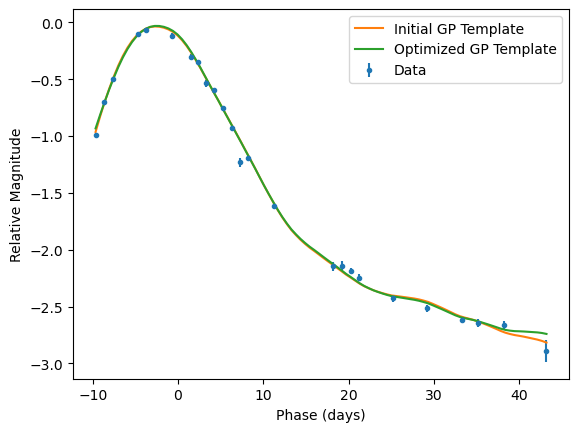

In [31]:
# Plotting data for a SN along with its initial GP fit and its optimized GP fit
# We want to see the effect of the smoothness term on smoothing the GP fit

plt.errorbar(all_sne[name][band]['x'],
             all_sne[name][band]['y'],
             yerr = all_sne[name][band]['yerr'],
            fmt = '.',
            label = 'Data')
plt.plot(all_sne[name][band]['t'],
         all_sne[name][band]['mu_init']+
         all_sne[name][band]['tmpl_t'],
         '-',
        label = 'Initial GP Template')
plt.plot(all_sne[name][band]['t'],
         all_sne[name][band]['mu_opt']+
         all_sne[name][band]['tmpl_t'],
         '-',
        label = 'Optimized GP Template')
plt.xlabel('Phase (days)')
plt.ylabel('Relative Magnitude')
plt.legend()

In [32]:
t_max_based_on_GP_opt = (all_sne[name][band]['t'][np.argmax(all_sne[name][band]['mu_opt']+
                                                            all_sne[name][band]['tmpl_t'])])

y_mag_closest = all_sne[name][band]['y_mag'][np.argmin(np.abs(all_sne[name][band]['x']-t_max_based_on_GP_opt))]

17.531


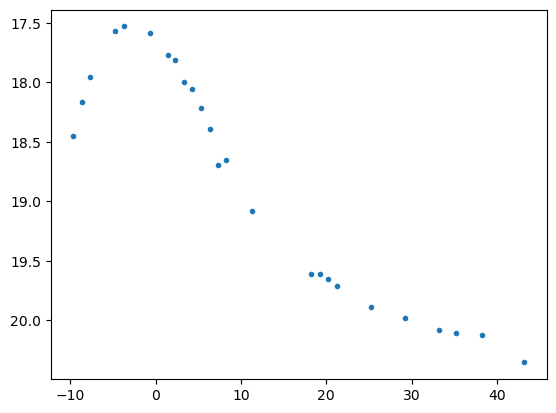

In [33]:
plt.plot(all_sne[name][band]['x'],
         all_sne[name][band]['y_mag'],
         '.')
print(y_mag_closest)
plt.gca().invert_yaxis()

In [59]:
all_peaks = {}

for s, sn in enumerate(all_sne_names):
    sn_tp = all_sne[sn]['type']
    sn_b_combos = list(combinations(list(all_sne[sn].keys())[1:], 2))
    for b_c in sn_b_combos:

        try:
            t_max_based_on_GP_opt_b1 = (all_sne[sn][b_c[0]]['t'][np.argmax(all_sne[sn][b_c[0]]['mu_opt']+
                                                                all_sne[sn][b_c[0]]['tmpl_t'])])
            t_max_based_on_GP_opt_b2 = (all_sne[sn][b_c[1]]['t'][np.argmax(all_sne[sn][b_c[1]]['mu_opt']+
                                                                all_sne[sn][b_c[1]]['tmpl_t'])])
            x_min_dist1 = np.abs(all_sne[sn][b_c[0]]['x'] - t_max_based_on_GP_opt_b1)
            x_min_dist2 = np.abs(all_sne[sn][b_c[1]]['x'] - t_max_based_on_GP_opt_b2)

            if np.min(x_min_dist1)<5 and np.min(x_min_dist2)<5:
                y_mag_closest1 = all_sne[sn][b_c[0]]['y_mag'][np.argmin(x_min_dist1)]
                y_mag_closest2 = all_sne[sn][b_c[1]]['y_mag'][np.argmin(x_min_dist2)]
                all_sne[sn]['%s-%s'%(b_c[0], b_c[1])] = y_mag_closest1 - y_mag_closest2
            else:
                print('SN %s in one or both of (%s, %s) bands has no observations close to the peak'%(sn, b_c[0], b_c[1]))
        except:
            pass

SN PS1-12sk in one or both of (g, ip) bands has no observations close to the peak
SN PS1-12sk in one or both of (rp, ip) bands has no observations close to the peak
SN PS1-12sk in one or both of (ip, J) bands has no observations close to the peak
SN PS1-12sk in one or both of (ip, w1) bands has no observations close to the peak
SN PS1-12sk in one or both of (ip, w2) bands has no observations close to the peak
SN PS1-12sk in one or both of (ip, m2) bands has no observations close to the peak
SN PTF10qts in one or both of (R, ip) bands has no observations close to the peak
SN PTF10qts in one or both of (rp, ip) bands has no observations close to the peak
SN sn1954A in one or both of (B, V) bands has no observations close to the peak
SN sn1997ef in one or both of (B, R) bands has no observations close to the peak
SN sn1997ef in one or both of (V, R) bands has no observations close to the peak
SN sn2003bg in one or both of (B, V) bands has no observations close to the peak
SN sn2003bg in o

In [86]:
all_combos = {}
for b_c in bands_combo:
    all_combos['%s-%s'%(b_c[0], b_c[1])] = []
    for sn in all_sne_names:
        if '%s-%s'%(b_c[0], b_c[1]) in list(all_sne[sn].keys()):
            all_combos['%s-%s'%(b_c[0], b_c[1])].append([all_sne[sn]['%s-%s'%(b_c[0], b_c[1])],
                                                         all_sne[sn]['type']])
    print('Found %i values for %s-%s color'%(len(all_combos['%s-%s'%(b_c[0], b_c[1])]),
                                             b_c[0], 
                                             b_c[1]))

Found 8 values for U-up color
Found 51 values for U-B color
Found 50 values for U-V color
Found 25 values for U-R color
Found 25 values for U-I color
Found 10 values for U-g color
Found 20 values for U-rp color
Found 20 values for U-ip color
Found 13 values for U-J color
Found 13 values for U-H color
Found 10 values for U-K color
Found 26 values for U-w1 color
Found 19 values for U-w2 color
Found 3 values for U-m2 color
Found 22 values for up-B color
Found 22 values for up-V color
Found 5 values for up-R color
Found 5 values for up-I color
Found 23 values for up-g color
Found 27 values for up-rp color
Found 26 values for up-ip color
Found 18 values for up-J color
Found 18 values for up-H color
Found 8 values for up-K color
Found 4 values for up-w1 color
Found 4 values for up-w2 color
Found 0 values for up-m2 color
Found 98 values for B-V color
Found 41 values for B-R color
Found 39 values for B-I color
Found 36 values for B-g color
Found 57 values for B-rp color
Found 56 values for B-i

In [125]:
all_colors = np.ones((len(all_sne_names), len(list(all_combos.keys()))))*np.nan

In [219]:
for s, sn in enumerate(all_sne_names):
    for b, b_c in enumerate(list(all_combos.keys())):
        if b_c in list(all_sne[sn].keys()):
            all_colors[s, b] = np.round(all_sne[sn][b_c], 2)

In [220]:
df = pd.DataFrame(data=all_colors,
                  columns= list(all_combos.keys()),
                  index = all_sne_names)

In [221]:
df = df.dropna(axis = 0, how = 'all')

In [222]:
df = df.dropna(axis = 1, how = 'all')

In [223]:
selected_colors = []
for col in df.columns:
    if col in ['B-R', 'B-I', 'V-ip', 'V-rp', 'R-I']:
        continue
    if len(df)-np.sum(np.isnan(df[col].values))> 30:
        if 'p' in col:
            col_ = col#.replace('p', "'")
        else:
            col_ = col
            
        selected_colors.append(col_)
        print('color %s has %i values.'%(col, len(df)-np.sum(np.isnan(df[col].values))))

color U-B has 51 values.
color U-V has 50 values.
color B-V has 98 values.
color B-g has 36 values.
color B-rp has 57 values.
color B-ip has 56 values.
color B-J has 37 values.
color B-H has 36 values.
color V-R has 42 values.
color V-I has 40 values.
color V-g has 32 values.
color V-J has 38 values.
color V-H has 37 values.
color g-rp has 56 values.
color g-ip has 52 values.
color rp-ip has 83 values.
color rp-J has 38 values.
color rp-H has 36 values.
color ip-J has 37 values.
color ip-H has 36 values.
color J-H has 37 values.


In [224]:
df.fillna('-', inplace=True)

In [225]:
df[selected_colors].to_latex(buf=output_directory + "all_SNe_peak_colors.tex",
                             columns = selected_colors,
                            longtable=True)

/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_15177/2684868096.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df[selected_colors].to_latex(buf=output_directory + "all_SNe_peak_colors.tex",
